In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from ggplot import *
from datetime import *

In [3]:
turnstile_weather = pd.read_csv('data/turnstile_data_master_with_weather.csv')
turnstile_weather.is_copy = False

In [4]:
turnstile_weather.rename(columns = lambda x: x.replace(' ', '_').lower(), inplace=True) 

In [5]:
turnstile_weather['week_day'] = turnstile_weather['daten'].map(
            lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())

In [6]:
def clean_hour(hour):
    if hour < 4:
        hour_bucket = 2
    if hour >= 4 and hour < 8:
        hour_bucket = 6
    if hour >= 8 and hour < 12:
        hour_bucket = 10
    if hour >= 12 and hour < 16:
        hour_bucket = 14
    if hour >= 16 and hour < 20:
        hour_bucket = 18
    if hour >= 20:
        hour_bucket = 22
    return hour_bucket

In [7]:
turnstile_weather['hour_bucket'] = turnstile_weather['hour'].map(clean_hour)

In [8]:
print turnstile_weather.columns

Index([u'unnamed:_0', u'unit', u'daten', u'timen', u'hour', u'descn',
       u'entriesn_hourly', u'exitsn_hourly', u'maxpressurei', u'maxdewpti',
       u'mindewpti', u'minpressurei', u'meandewpti', u'meanpressurei', u'fog',
       u'rain', u'meanwindspdi', u'mintempi', u'meantempi', u'maxtempi',
       u'precipi', u'thunder', u'week_day', u'hour_bucket'],
      dtype='object')


In [9]:
print turnstile_weather[['daten', 'timen', 'hour', 'hour_bucket', 'entriesn_hourly']]

             daten     timen  hour  hour_bucket  entriesn_hourly
0       2011-05-01  01:00:00     1            2                0
1       2011-05-01  05:00:00     5            6              217
2       2011-05-01  09:00:00     9           10              890
3       2011-05-01  13:00:00    13           14             2451
4       2011-05-01  17:00:00    17           18             4400
5       2011-05-01  21:00:00    21           22             3372
6       2011-05-01  01:00:00     1            2                0
7       2011-05-01  05:00:00     5            6               42
8       2011-05-01  09:00:00     9           10               50
9       2011-05-01  13:00:00    13           14              316
10      2011-05-01  17:00:00    17           18              633
11      2011-05-01  21:00:00    21           22              639
12      2011-05-01  00:00:00     0            2                0
13      2011-05-01  04:00:00     4            6                0
14      2011-05-01  12:00

In [10]:
import pandasql
q = """
select hour_bucket, sum(entriesn_hourly)
from turnstile_weather
group by hour_bucket
"""
entries_hour_bucket = pandasql.sqldf(q.lower(), locals())

In [11]:
print entries_hour_bucket

   hour_bucket  sum(entriesn_hourly)
0            2              16286279
1            6               4184721
2           10              18497445
3           14              33835888
4           18              32553515
5           22              39174479


We can now plot the result.

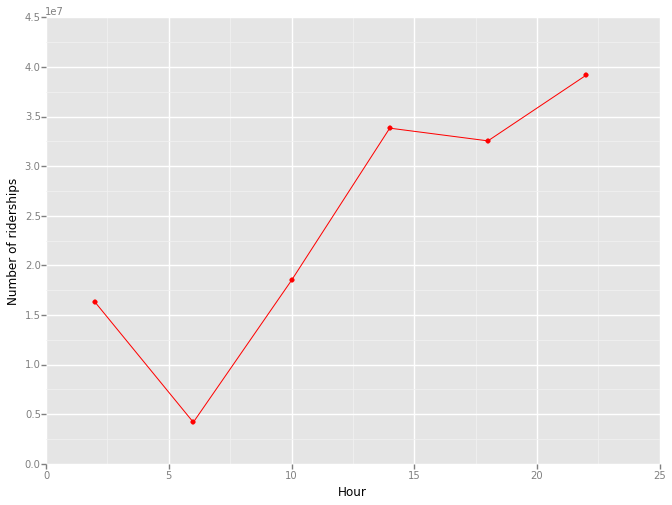

<ggplot: (285771673)>

In [12]:
ggplot(entries_hour_bucket, aes('hour_bucket', 'sum(entriesn_hourly)')) + geom_point(color='red') + \
    geom_line(color='red') + xlab('Hour') + ylab('Number of riderships')

Select the top 4 stations

In [13]:
q = """
select unit, sum(entriesn_hourly)
from turnstile_weather
group by unit
"""
entries_unit = pandasql.sqldf(q.lower(), locals())

In [14]:
entries_unit_top_5 = entries_unit.sort(columns='sum(entriesn_hourly)', ascending=False).head(5)
unit_top_5 = entries_unit_top_5['unit'].values
print unit_top_5

[u'R170' u'R084' u'R022' u'R033' u'R046']


In [15]:
turnstile_weather_small = turnstile_weather[turnstile_weather['unit'].isin(unit_top_5)]

In [16]:
print turnstile_weather_small

        unnamed:_0  unit       daten     timen  hour    descn  \
120            120  R022  2011-05-01  00:00:00     0  REGULAR   
121            121  R022  2011-05-01  04:00:00     4  REGULAR   
122            122  R022  2011-05-01  08:00:00     8  REGULAR   
123            123  R022  2011-05-01  12:00:00    12  REGULAR   
124            124  R022  2011-05-01  16:00:00    16  REGULAR   
125            125  R022  2011-05-01  20:00:00    20  REGULAR   
183            183  R033  2011-05-01  00:00:00     0  REGULAR   
184            184  R033  2011-05-01  04:00:00     4  REGULAR   
185            185  R033  2011-05-01  08:00:00     8  REGULAR   
186            186  R033  2011-05-01  12:00:00    12  REGULAR   
187            187  R033  2011-05-01  16:00:00    16  REGULAR   
188            188  R033  2011-05-01  20:00:00    20  REGULAR   
277            277  R046  2011-05-01  00:00:00     0  REGULAR   
278            278  R046  2011-05-01  04:00:00     4  REGULAR   
279            279  R046 

In [19]:
q = """
select unit, week_day, hour_bucket, sum(entriesn_hourly)
from turnstile_weather_small
group by unit, week_day, hour_bucket
"""
entries_unit_week_day = pandasql.sqldf(q.lower(), locals())

In [20]:
print entries_unit_week_day

     unit  week_day  hour_bucket  sum(entriesn_hourly)
0    R022         0            2                 34234
1    R022         0            6                  4624
2    R022         0           10                  7814
3    R022         0           14                 37013
4    R022         0           18                 64641
5    R022         0           22                134500
6    R022         1            2                 43604
7    R022         1            6                 10916
8    R022         1           10                  8830
9    R022         1           14                 27523
10   R022         1           18                 53855
11   R022         1           22                118498
12   R022         2            2                 52779
13   R022         2            6                 15672
14   R022         2           10                  4867
15   R022         2           14                 38681
16   R022         2           18                 61354
17   R022 

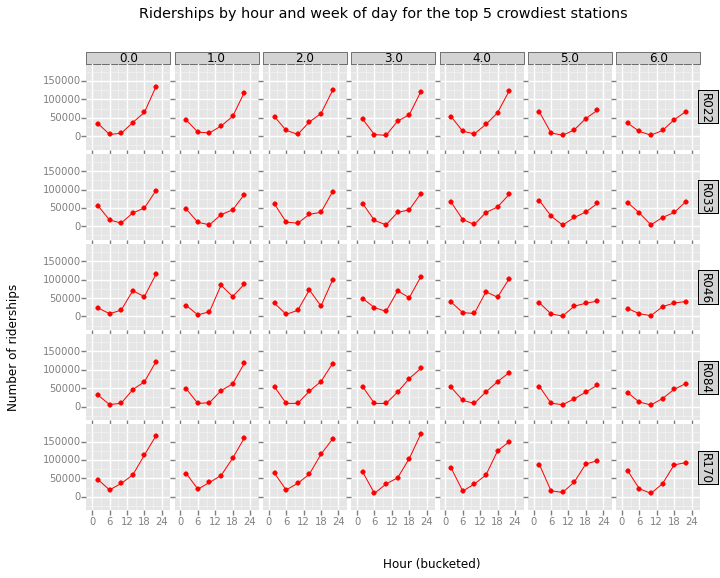

<ggplot: (282753197)>

In [22]:
ggplot(entries_unit_week_day, aes('hour_bucket', 'sum(entriesn_hourly)')) + \
    geom_point(color='red') + geom_line(color='red') + \
    facet_grid('unit', 'week_day') + \
    xlab('Hour (bucketed)') + ylab('Number of riderships') + \
    ggtitle("Riderships by hour and week of day for the top 5 crowdiest stations")

Same bo